# Cluster the mission statements of the nonprofits

Take the not-for-profit organization name and/or their mission statement from  Form 990/Form 990N data and identify natural groupings to help categorize them.

For this, we only used charities in GA, IL, MI, MT, and NY. 

In [1]:
%matplotlib inline
import csv
import glob
import os
import re
import matplotlib.pyplot as plt
import numpy as np

from collections import Counter
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

plt.rcParams['figure.figsize'] = (12, 7)

In [2]:
# Go through all of the entries from all of the Form 990 tax forms.
# We want
#  - the EIN number (to identify the business)
#  - their business name (because sometimes that's all there is)
#  - their mission statement(s)
state_paths = glob.glob(os.path.join('data', 'form990', '*'))
nfp_names = {}  # Map the EIN number to the business name
missions = {}  # Map the EIN number to the mission statement(s)
for dirname in state_paths:
    cities_990 = glob.glob(os.path.join(dirname, '*'))
    for fname in cities_990:
        with open(fname) as infile:
            rdr = csv.reader(infile, delimiter='\t')
            nfp_names_etc = [
                (row[0], row[1], row[30], row[-1], row[-2])
                for row in rdr
            ]
            nfp_names.update(dict(entry[:2] for entry in nfp_names_etc))
            missions.update(dict(
                    (entry[0], '  '.join(set(entry[1:])))  # remove duplicates
                    for entry in nfp_names_etc
            ))

In [3]:
# Also go through the Form 990N tax forms.
# We want
#  - the EIN number (to identify the business)
#  - their business name (there is no mission statement)
state_paths = glob.glob(os.path.join('data', 'form990N', '*'))
for dirname in state_paths:
    cities_990 = glob.glob(os.path.join(dirname, '*'))
    for fname in cities_990:
        with open(fname) as infile:
            rdr = csv.reader(infile, delimiter='\t')
            ein_to_name = dict((row[0], row[1]) for row in rdr)
            nfp_names.update(ein_to_name)
            # Missions too (use the name as the mission for 990Ns)...
            missions.update(ein_to_name)

In [4]:
# The tokenizer will split out words to help autogenerate
# 'tags' for the Nonprofit names/missions using the
# Natural Language Toolkit
def tokenize(
        phrase,
        space_or_punct=re.compile("[\s,:!\.]+"),
        stemmer=PorterStemmer(),
        stopwords=stopwords.words("English")):
    split_phrase = space_or_punct.split(phrase.lower())
    return set(stemmer.stem(word)
               for word in split_phrase
               if word not in stopwords and len(word))

In [5]:
tokenized_missions = dict(
    (ein, tokenize(msg)) for ein, msg in missions.items()
)
word_counts = Counter(
    word for mission in tokenized_missions.values() for word in mission
)

print('Most common:')
print(word_counts.most_common(3))
print('\nLeast common:')
print(word_counts.most_common()[-3:])

# Delete anything with too few occurrences (say less than 1%)
low_thresh = len(word_counts) // 1000
high_thresh = len(word_counts) // 3
excluded_words = set([str(yr) for yr in range(2007,2017)])
print('Initial number of words:', len(word_counts))
for k in sorted(word_counts.keys()):
    if word_counts[k] < low_thresh or word_counts[k] > high_thresh:
        excluded_words.add(word_counts[k])
        del word_counts[k]


print('Words occurring {} to {} times'.format(low_thresh, high_thresh))
print('words remaining:', len(word_counts))

Most common:
[('2015', 49758), ('2014', 43442), ('provid', 17054)]

Least common:
[('webr', 1), ('studiesschool', 1), ('families/visitor', 1)]
Initial number of words: 56527
Words occurring 56 to 18842 times
words remaining: 2277


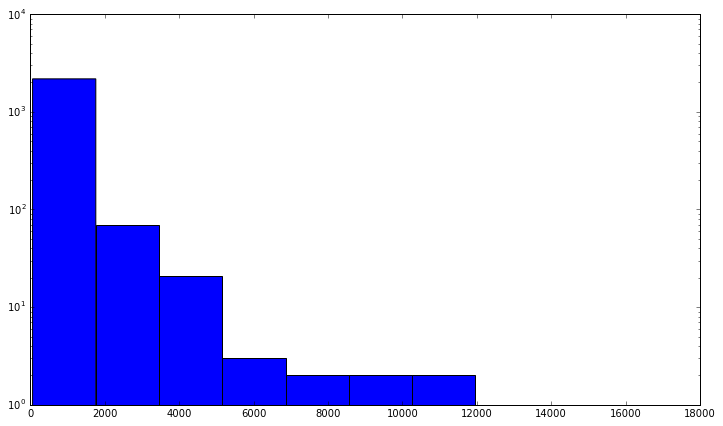

In [6]:
__ = plt.hist(sorted(word_counts.values()), log=True)

In [7]:
#from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import k_means
from sklearn.feature_extraction.text import HashingVectorizer

In [8]:
sorted_nfps = sorted(tokenized_missions.keys())

token_matrix = HashingVectorizer().transform(
    ' '.join(tokenized_missions[ein])
    for ein in sorted_nfps
)

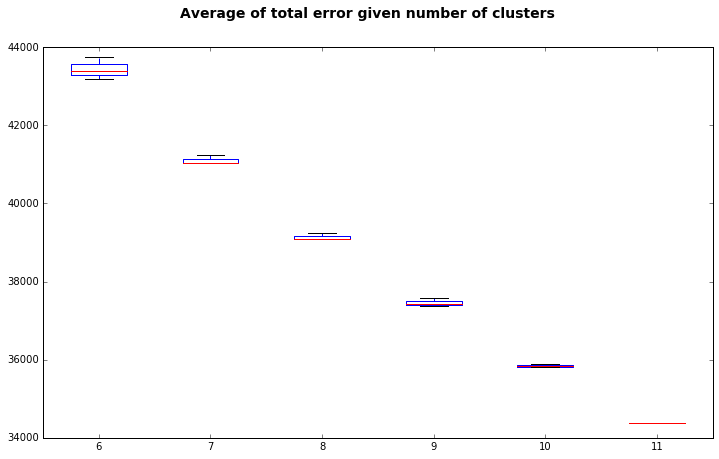

In [9]:
mean_distances = {}
for k in range(6, 12):
    mean_distances[k] = [
        k_means(token_matrix, k)[-1]
        for i in range(3)
    ]

keys = sorted(mean_distances.keys())
ax = plt.boxplot([mean_distances[k] for k in keys], labels=keys)
__ = plt.suptitle(
    'Average of total error given number of clusters',
    fontweight='bold', fontsize=14
)

In [10]:
num_clusters = 10
centers, labels, inertia =  k_means(token_matrix, num_clusters)

In [11]:
clustered_eins = {}
for label, ein in zip(labels, sorted_nfps):
    if label not in clustered_eins:
        clustered_eins[label] = [ein]
    else:
        clustered_eins[label].append(ein)

In [12]:
clustered_counters = {}
for label, eins in clustered_eins.items():
    clustered_counters[label] = Counter(
        word 
        for ein in eins
            for word in  tokenized_missions[ein]
            if word not in excluded_words
    )
    print('~' * 20)
    print(label, 'size:', len(eins))
    print(clustered_counters[label].most_common(10))

~~~~~~~~~~~~~~~~~~~~
0 size: 41387
[('fee', 889), ('expens', 603), ('file', 373), ('bank', 343), ('invest', 238), ('charg', 228), ('round', 201), ('incom', 191), ('adjust', 173), ('tax', 172)]
~~~~~~~~~~~~~~~~~~~~
1 size: 20147
[('fee', 579), ('expens', 484), ('bank', 398), ('charg', 276), ('file', 201), ('incom', 167), ('none', 125), ('invest', 118), ('receiv', 103), ('miscellan', 81)]
~~~~~~~~~~~~~~~~~~~~
2 size: 1525
[]
~~~~~~~~~~~~~~~~~~~~
3 size: 2136
[]
~~~~~~~~~~~~~~~~~~~~
4 size: 2220
[]
~~~~~~~~~~~~~~~~~~~~
5 size: 2699
[]
~~~~~~~~~~~~~~~~~~~~
6 size: 32955
[('provid', 17054), ('educ', 10449), ('program', 10399), ('servic', 9956), ('commun', 9341), ('organ', 8017), ('support', 7869), ('develop', 5891), ('care', 5170), ('promot', 4922)]
~~~~~~~~~~~~~~~~~~~~
7 size: 1936
[]
~~~~~~~~~~~~~~~~~~~~
8 size: 3885
[('fee', 52), ('bank', 41), ('charg', 26), ('file', 19), ('expens', 17), ('incom', 14), ('interest', 11), ('invest', 9), ('tax', 8), ('none', 8)]
~~~~~~~~~~~~~~~~~~~~
9 size: